In [1]:
import numpy as np
# from scipy.optimize import fsolve

# %matplotlib notebook
# %matplotlib inline

import matplotlib.pyplot as plt
# print(plt.style.available)  # show available template
plt.style.use(['seaborn-ticks','seaborn-paper'])  # use a templet

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'
params = {
    'figure.figsize': [8, 6], # Note! figure unit is inch!  scale fontz size 2.54 to looks like unit cm
    'axes.labelsize': 7.5*2.54, # scale 2.54 to change to figure unit looks as cm
    'font.size':  7.5*2.54,
    'lines.linewidth':2,
    'axes.linewidth': 1.0,  # default 1.25
    'legend.fontsize': 6*2.54,
    'xtick.labelsize': 7.5*2.54,
    'ytick.labelsize': 7.5*2.54,
    'text.usetex': False,  
    'xtick.direction': "in",
    'ytick.direction': "in", # ticket inside
    'legend.frameon' : True, 
    'legend.edgecolor': 'black',
    'legend.shadow': True,
    'legend.framealpha':1,
#     'patch.linewidth' : 0.5, 
}
mpl.rcParams.update(params)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


In [2]:
def carry_PHS(state, theta, chi):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2)-1j*np.sin(theta/2)*np.sin(chi), -np.sin(theta/2)*np.cos(chi)],[np.sin(theta/2)*np.cos(chi), np.cos(theta/2)+1j*np.sin(theta/2)*np.sin(chi)]])
	final_state = np.dot(U, state)

	return final_state    

def sigmaz(state):
	U = np.array([[1, 0],[0, -1]])
	final_state = np.dot(U, state)

	return final_state   

def carry(state, theta):
	'''
	carry U operatior on state
	suppose U=exp(-i*theta/2*sigmay)
	'''
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	final_state = np.dot(U, state)

	return final_state

def blue_carry(state, theta):
	'''
	blue carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number plus 1
	|1>-->|0>, phonon number minus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, down level minus 1
	up_state = carry_state_up[0]
	down_state_minus = carry_state_up[1]
	down_state_minus_0 = state_up[0][0]  # blue carry can not drive the phonon=0 && up level
	down_state_minus = np.delete(down_state_minus, 0)
	down_state_minus = np.insert(down_state_minus, len(down_state_minus)-1, 0)
	# after U operation, up level plus 1
	up_state_plus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_plus = np.insert(up_state_plus, 0, down_state_minus_0)
	up_state_plus = np.delete(up_state_plus, len(up_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_plus
	down = down_state_minus + down_state
	final_state = np.vstack((up, down))

	return final_state

def red_carry(state, theta):
	'''
	red carry U on state
	suppose U=exp(-i*theta/2*sigmay)
	and |0>-->|1>,phonon number minus 1
	|1>-->|0>, phonon number plus 1
	'''
	# U operator on up and down level of state
	state_up = np.vstack((state[0], np.zeros(len(state[0]))))
	state_down = np.vstack((np.zeros(len(state[0])), state[1]))
	U = np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
	carry_state_up = np.dot(U, state_up)
	carry_state_down = np.dot(U, state_down)
	# after U operation, up level minus 1
	up_state_minus = carry_state_down[0]
	down_state = carry_state_down[1]
	up_state_minus_0 = state_down[1][0] # red carry can not drive the phonon=0 && down level
	up_state_minus = np.delete(up_state_minus,0)
	up_state_minus = np.insert(up_state_minus,len(up_state_minus)-1,0)
	# after U operation, down level plus 1
	up_state = carry_state_up[0]
	down_state_plus = carry_state_up[1]
	down_state_plus = np.insert(down_state_plus,0,up_state_minus_0)
	down_state_plus = np.delete(down_state_plus,len(down_state_plus)-1)
	# probability add up and down level
	up = up_state + up_state_minus
	down = down_state_plus + down_state
	final_state = np.vstack((up, down))

	return final_state

def Operator(up_state, down_state, func, theta):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = func(state, theta)

	return state[0], state[1]

def operator(up_state, down_state, theta, chi):
	'''
	operator include carry, blue and red
	'''
	state = np.vstack((up_state, down_state))
	state = carry_PHS(state, theta, chi)

	return state[0], state[1]

def Sigmaz(state):
	'''
	operator include carry, blue and red
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	s = np.vstack((up_state, down_state))
	s = sigmaz(s)
	rs = np.vstack((s[0],s[1],aux_state))
	return rs

def one_step_1(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T2R2T1R1
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_1)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, red_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_2)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, blue_carry, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state


# def One_step_1(state, theta_1, theta_2):
# 	'''
# 	one step of complete quantum walk
# 	may with the help of auxiliary level
# 	input state of three level
# 	output state of three level
# 	T1:up-->right
# 	t2:down-->left 
# 	T2R2T1R1
# 	'''
# 	up_state = state[0]
# 	down_state = state[1]
# 	aux_state = state[2]
# 	up_state, down_state = Operator(up_state, down_state, carry, theta_1)
# 	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
# 	up_state, down_state = Operator(up_state, down_state, red_carry, np.pi)
# 	aux_state, down_state = Operator(aux_state, down_state, carry, theta_2)
# 	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
# 	aux_state, down_state = Operator(aux_state, down_state, blue_carry, np.pi)
# 	up_state[0] = - up_state[0]
# 	state = np.vstack((up_state, down_state, aux_state))
# 	return state

def one_step_2(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)

	state = np.vstack((up_state, down_state, aux_state))
	return state

def One_step_2(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	T1R1T2R2
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state[0] = - up_state[0]
	state = np.vstack((up_state, down_state, aux_state))
	return state



def One_step_4(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state[0] = - up_state[0]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step_4(state, theta_1, theta_2):
	'''
	one step of complete quantum walk
	may with the help of auxiliary level
	input state of three level
	output state of three level
	T1:up-->right
	t2:down-->left 
	r2T1R1T2r2  r2=sqrt(R2)
	'''
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, theta_1)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, theta_2/2)
	
	state = np.vstack((up_state, down_state, aux_state))
	return state

def one_step(state, theta_1, theta_2, chi):
	up_state = state[0]
	down_state = state[1]
	aux_state = state[2]
	up_state, down_state = operator(up_state, down_state, theta_2, chi)
	aux_state, down_state = Operator(aux_state, down_state, red_carry, np.pi)
	up_state, down_state = Operator(up_state, down_state, carry, np.pi)
	aux_state, down_state = operator(aux_state, down_state, theta_1, chi)
	up_state, down_state = Operator(up_state, down_state, blue_carry, np.pi)
	aux_state, down_state = Operator(aux_state, down_state, carry, np.pi)
	up_state[0] = up_state[0]
	state = np.vstack((up_state, down_state, aux_state))
	return state
	
	state = np.vstack((up_state, down_state, aux_state))
	return state


def N_step_1(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_1(state, theta_1, theta_2)
	return state

def n_step_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_2(state, theta_1, theta_2)
	return state

def N_step_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = One_step_2(state, theta_1, theta_2)
	return state

def n_step(state, theta_1, theta_2, chi, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step(state, theta_1, theta_2, chi)
	return state


# def N_step_3(state, theta_1, theta_2, N):
# 	'''
# 	N step of complete quantum walk
# 	'''
# 	for i in range(N):
# 		state = one_step_3(state, theta_1, theta_2)
# 	return state

def N_step_4(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_4(state, theta_1, theta_2)
	return state

def N_STEP_2(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = One_step_2(state, theta_1, theta_2)
	return state

def n_step_4(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = one_step_4(state, theta_1, theta_2)
	return state

def N_step_4(state, theta_1, theta_2, N):
	'''
	N step of complete quantum walk
	'''
	for i in range(N):
		state = One_step_4(state, theta_1, theta_2)
	return state


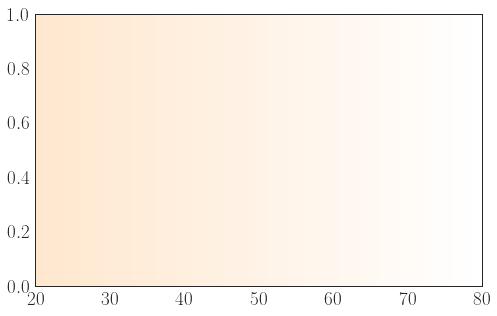

In [4]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


c2='#F8BD82'
c1='#FFE7CE'
c3='w'
c4='#F7E7F7'
n=500

fig, ax = plt.subplots(figsize=(8, 5))
plt.xlim(20,80)
for x in range(n+1):
    ax.axvline(x/500*60+20, color=colorFader(c1,c3,x/n), linewidth=3)
plt.show()

In [6]:
n0 = 20
n1 = 2
n2 = 5
n3 = 10
n4 = 15
n5 = 20
nq = 20
N=80
def neighbour(theta_1, theta_2, theta_3, init_state, n0, nq,N):
    p_1 = np.zeros(M+1)
    p_1[0]=1

    for i in range(N): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)

        elif i > 0 and i < n0:
            state1 = one_step_4(state1, theta_1, theta_2)
#         elif i == n0:
#             state1 = -Sigmaz(state1)
#             state1 = one_step_4(state1, theta_1, theta_2)
            
        elif i >= n0 and i < n0 + nq:
            t1 = theta_2+(theta_3-theta_2)/nq * (i-n0)
            state1 = one_step_4(state1, theta_1, t1)
#         elif i == n0 + nq:
#             state1 = Sigmaz(state1)
#             state1 = one_step_4(state1, theta_1, theta_3)
        elif i >= n0 + nq:
            state1 = one_step_4(state1, theta_1, theta_3)        
            
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+1] = P1[0] + P1[1]
  
    return p_1


def nneighbour(theta_1, theta_2, theta_3, init_state, n0, nq, N):
    p_1 = np.zeros(M+1)
    p_1[0]=1

    for i in range(N): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)

        elif i > 0 and i < n0:
            state1 = one_step_4(state1, theta_1, theta_2)
#         elif i == n0:
#             state1 = -Sigmaz(state1)
#             state1 = one_step_4(state1, theta_1, theta_2)
            
        elif i >= n0 and i < n0 + nq:
            t1 = theta_2+(theta_3-theta_2)/nq * (i-n0)
            state1 = one_step_4(state1, theta_1, t1)
        elif i == n0 + nq:
            state1 = Sigmaz(state1)
            state1 = one_step_4(state1, theta_1, theta_3)
        elif i > n0 + nq:
            state1 = one_step_4(state1, theta_1, theta_3)        
            
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+1] = P1[0] + P1[1]
  
    return p_1

def Neighbour(theta_1, theta_2, theta_3, init_state, n0, nq, N):
    p_1 = np.zeros(M+1)
    p_1[0]=1
    for i in range(N): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)
        elif i > 0 and i < n0:
            state1 = one_step_4(state1, theta_1, theta_2)
        elif i >= n0 and i < n0 + nq:
            t1 = theta_1+(theta_3-theta_1)/nq * (i-n0)
            state1 = one_step_4(state1, t1, theta_2)
        elif i >= n0 + nq:
            state1 = one_step_4(state1, theta_3, theta_2)
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+1] = P1[0] + P1[1]

    return p_1

In [4]:
M = 1000
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
def monitor_spin_sigma(theta_1, theta_2, theta_3, init_state, n0, nq, N):
    p_1 = np.zeros(M+1)
    p_1[0] = 1
    a = np.zeros(N)
    b = np.zeros(N)
    for i in range(N): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)
    
        elif i > 0 and i < n0:
            state1 = one_step_4(state1, theta_1, theta_2)


            
        elif i >= n0 and i < n0 + nq:
            t1 = theta_2+(theta_3-theta_2)/nq * (i-n0)
            state1 = one_step_4(state1, theta_1, t1)


        elif i == n0 + nq:
            state1 = Sigmaz(state1)
            state1 = one_step_4(state1, theta_1, theta_3)

        elif i > n0 + nq:
            state1 = one_step_4(state1, theta_1, theta_3) 

        a[i] = state1[1][0] / state1[0][0]
        b[i] = state1[1][1] / state1[0][1]
        
    return 2*a/(a**2+1), 2*b/(b**2+1)

def monitor_spin(theta_1, theta_2, theta_3, init_state, n0, nq, N):
    a = np.zeros(N)
    b = np.zeros(N)
    for i in range(N): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)


        elif i > 0 and i < n0:
            state1 = one_step_4(state1, theta_1, theta_2)

            
        elif i >= n0 and i < n0 + nq:
            t1 = theta_2+(theta_3-theta_2)/nq * (i-n0)
            state1 = one_step_4(state1, theta_1, t1)


        elif i >= n0 + nq:
            state1 = one_step_4(state1, theta_1, theta_3) 
        a[i] = state1[1][0] / state1[0][0]
        b[i] = state1[1][1] / state1[0][1]
    return 2*a/(a**2+1), 2*b/(b**2+1)

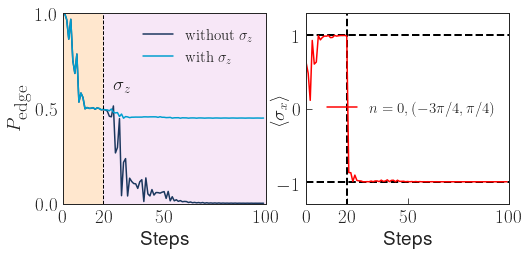

In [181]:
n0 = 20
n1 = 1
N = 100
n=500
T=range(N)
fig, axes = plt.subplots(1,2,figsize=(8,3.5))

theta_1 = np.pi/4
theta_2 = 3*np.pi/4
theta_3 = -3*np.pi/4
p_1 =  neighbour(theta_1, theta_2, theta_3, init_state,n0,n1,N)[0:N]
p_2 =  nneighbour(theta_1, theta_2, theta_3, init_state,n0,n1,N)[0:N]

axes[0].fill_between(np.linspace(0,20,25),1,0,color=c1)
axes[0].fill_between(np.linspace(20,N,25),1,0,color=c4)

axes[0].plot(T, p_1,lw=1.5,c='#1B375E',label=r'$\textrm{without}\ \sigma_z$')
axes[0].plot(T, p_2,lw=1.5,c='#009ECF',label=r'$\textrm{with}\ \sigma_z$')
axes[0].axvline(n0,c='black', linewidth=1,ls = "dashed")
axes[0].set_xlim(0,N)
axes[0].set_ylim(0,1)
axes[0].set_yticks([0,0.5,1])
axes[0].set_xlabel('Steps')
axes[0].set_ylabel(r'$P_{\textrm{edge}}$')
axes[0].legend(loc='best',fontsize=15,frameon=False)
axes[0].text(25, 0.6, r'$\sigma_z$')
axes[0].set_xticks([0,20,50,100])

a,b = monitor_spin_sigma(theta_1, theta_2, theta_3, init_state, n0, n1, N)
axes[1].plot(range(N),a,c='r',lw=1.5,label=r'$n=0, (-3\pi/4,\pi/4)$')

axes[1].hlines(1, 0, 200, linestyles = "dashed",lw=2)
axes[1].hlines(-1, 0, 200, linestyles = "dashed",lw=2)
axes[1].vlines(n0,-2.2,2.2, linestyles = "dashed",lw=2)
axes[1].set_ylim(-1.3,1.3)
axes[1].set_xlim(0,N)
axes[1].set_xlabel('Steps')
axes[1].set_ylabel(r'$\left\langle \sigma_{x}\right\rangle$',labelpad=-12)
axes[1].set_xticks([0,20,50,100])
axes[1].legend(loc='best',fontsize=15,frameon=False)
plt.savefig('../Figure/quenchsigma.pdf')

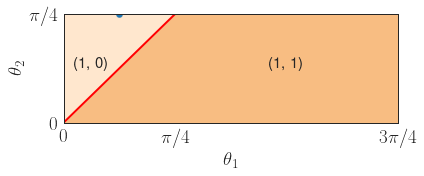

In [88]:
plt.figure(figsize=(6,2))
plt.xlim((0, 3*np.pi/4))
plt.xticks([0,np.pi/4,3*np.pi/4], (r'$0$', r'$\pi/4$', r'$3\pi/4$'))
plt.ylim((0, np.pi/4))
plt.yticks([0, np.pi/4], (r'$0$', r'$\pi/4$'))
T = np.linspace(0, np.pi/4, 50)
TT = np.linspace(0, 3*np.pi/4, 100) 
plt.plot(T, T, c='r', linewidth=2)
def f(t):
    if t > np.pi/4:
        return np.pi/4
    elif t <= np.pi/4:
        return t

    
plt.fill_between(TT ,[f(t) for t in TT],color=c2)
plt.fill_between(TT ,np.ones(100)*np.pi/4,[f(t) for t in TT],color=c1)


plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.text(np.pi/16, np.pi/8, '(1, 0)', ha='center', fontsize=15)
plt.text(np.pi/2, np.pi/8, '(1, 1)', ha='center', fontsize=15)

In [133]:
n1 = 1
n2 = 4
n3 = 6
n4 = 8
n5 = 10
n0=20
theta_1 = np.pi/4
theta_2 = 3*np.pi/4
theta_3 = np.pi/8
t = range(1,31)
p1=np.zeros(30)
for i in range(30):
    p1[i] = neighbour(theta_1, theta_2, theta_3, init_state,n0,i+1,N)[0:N][-1]

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
 
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
 
popt1, pcov1 = curve_fit(func, t, p1)

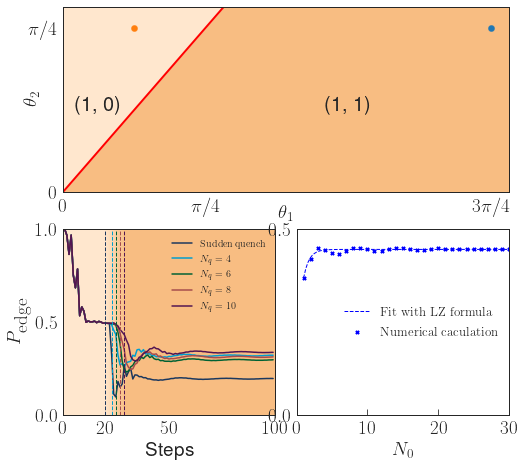

In [182]:
plt.figure(figsize=(8,7.5))
grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.2)
plt.subplot(grid[0,:])

plt.xlim((0, 3*np.pi/4+0.1))
plt.xticks([0,np.pi/4,3*np.pi/4], (r'$0$', r'$\pi/4$', r'$3\pi/4$'))
plt.ylim((0, np.pi/4+0.1))
plt.yticks([0, np.pi/4], (r'$0$', r'$\pi/4$'))
T = np.linspace(0, np.pi/4+0.2, 50)
TT = np.linspace(0, 3*np.pi/4+0.2, 100) 
plt.plot(T, T, c='r', linewidth=2)
def f(t):
    if t > np.pi/4+0.1:
        return np.pi/4+0.2
    else:
        return t

    
plt.fill_between(TT ,[f(t) for t in TT],color=c2)
plt.fill_between(TT ,np.ones(100)*(np.pi/4+0.1),[f(t) for t in TT],color=c1)


plt.xlabel(r'$\theta_1$',labelpad=-12)
plt.ylabel(r'$\theta_2$',labelpad=-12)
plt.text(np.pi/16, np.pi/8, '(1, 0)', ha='center', fontsize=20)
plt.text(np.pi/2, np.pi/8, '(1, 1)', ha='center', fontsize=20)
plt.scatter(3*np.pi/4, np.pi/4,s=40)
plt.scatter(np.pi/8, np.pi/4,s=40)

ax1 = plt.subplot(grid[1:,0])

theta_1 = np.pi/4
theta_2 = 3*np.pi/4
theta_3 = -np.pi/16
p_1 =  neighbour(theta_1, theta_2, theta_3, init_state,n0,n1,N)[0:N]
p_2 =  neighbour(theta_1, theta_2, theta_3, init_state,n0,n2,N)[0:N]
p_3 =  neighbour(theta_1, theta_2, theta_3, init_state,n0,n3,N)[0:N]
p_4 =  neighbour(theta_1, theta_2, theta_3, init_state,n0,n4,N)[0:N]
p_5 =  neighbour(theta_1, theta_2, theta_3, init_state,n0,n5,N)[0:N]
T = range(N)
ax1.fill_between(np.linspace(0,20,25),1,0,color=c1)
ax1.fill_between(np.linspace(20+n5,N,25),1,0,color=c2)
for x in range(n+1):
    ax1.axvline(x/500*n5+20, color=colorFader(c1,c2,x/n), linewidth=3)
ax1.plot(T, p_1,lw=1.5,c='#1B375E',label=r'$\textrm{Sudden quench}$')
ax1.plot(T, p_2,lw=1.5,c='#009ECF',label=r'$N_q=4$')
ax1.plot(T, p_3,lw=1.5,c='#006133',label=r'$N_q=6$')
ax1.plot(T, p_4,lw=1.5,c='#a64c4c',label=r'$N_q=8$')
ax1.plot(T, p_5,lw=1.5,c='#521552',label=r'$N_q=10$')
ax1.set_ylim((0,1))
ax1.set_xlim((0,N))
ax1.axvline(n0, color='#1B375E', linewidth=1,ls = "dashed")
ax1.axvline(n0+n2-1, 0, 1, linewidth=1,ls = "dashed",color='#009ECF')
ax1.axvline(n0+n3-1, 0, 1, linewidth=1,ls = "dashed",color='#006133')
ax1.axvline(n0+n4-1, 0, 1, linewidth=1,ls = "dashed",color='#a64c4c')
ax1.axvline(n0+n5-1, 0, 1, linewidth=1,ls = "dashed",color='#521552')
ax1.set_xticks([0,20,50,100])
ax1.set_xlabel('Steps')
ax1.set_ylabel(r'$P_{\textrm{edge}}$')
ax1.set_yticks([0,0.5,1])
ax1.legend(loc='best',fontsize=10,frameon=False)

ax2 = plt.subplot(grid[1:,1])
ax2.scatter(range(1,31),p1,s=10,c='blue',marker='x',label=r'$\textrm{Numerical caculation}$')
x=np.linspace(1,31,100)
ax2.plot(x,[func(i, popt1[0],popt1[1],popt1[2]) for i in x],c='blue',lw=1,ls='--',label=r'$\textrm{Fit with LZ formula}$')
ax2.set_ylim(0,0.5)
ax2.set_yticks([0,0.5])
ax2.set_xlim(0,30)
ax2.set_xlabel(r'$N_0$')
ax2.legend(loc='right',fontsize=13,frameon=False)
plt.savefig('../Figure/quenchspeed.pdf')


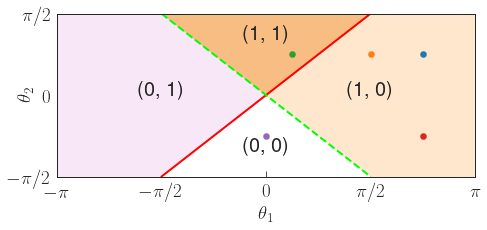

In [178]:
plt.figure(figsize=(7.5,3))
plt.xlim((-np.pi, np.pi))
plt.xticks([0,-np.pi,np.pi,-np.pi/2,np.pi/2], (r'$0$', r'$-\pi$', r'$\pi$', r'$-\pi/2$', r'$\pi/2$'))
plt.ylim((-np.pi/2, np.pi/2))
plt.yticks([0, -np.pi/2, np.pi/2], (r'$0$', r'$-\pi/2$', r'$\pi/2$'))
T = np.linspace(-np.pi/2, np.pi/2, 50)
T1 = np.linspace(-np.pi, 0, 100)
T2 = np.linspace(0,np.pi,100)
T3 = np.linspace(-np.pi/2,np.pi/2,100)
plt.plot(T, T, c='r', linewidth=2)
plt.plot(T, -T, linewidth=2,  c='#00FF00',ls='--')
def f(t):
    if t > np.pi/4:
        return np.pi/4
    elif t <= np.pi/4:
        return t

    
plt.fill_between(T1 ,T1, -T1, color=c4)
plt.fill_between(T2 ,-T2, T2, color=c1)
plt.fill_between(T3, np.ones(100)*np.pi/2, abs(T3), color=c2)



plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$',labelpad=-27)
plt.text(np.pi/2, 0, '(1, 0)', ha='center', fontsize=20)
plt.text(-np.pi/2, 0, '(0, 1)', ha='center', fontsize=20)
plt.text(0, np.pi/4+0.3, '(1, 1)', ha='center', fontsize=20)
plt.text(0, -np.pi/4-0.3, '(0, 0)', ha='center', fontsize=20)
plt.scatter(3*np.pi/4,np.pi/4,s=40)
plt.scatter(np.pi/2,np.pi/4,s=40)
plt.scatter(np.pi/8,np.pi/4,s=40)
plt.scatter(3*np.pi/4,-np.pi/4,s=40)
plt.scatter(0,-np.pi/4,s=40)
plt.savefig('../Figure/quench_0.pdf')

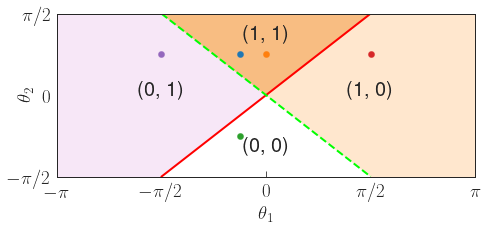

In [179]:
plt.figure(figsize=(7.5,3))
plt.xlim((-np.pi, np.pi))
plt.xticks([0,-np.pi,np.pi,-np.pi/2,np.pi/2], (r'$0$', r'$-\pi$', r'$\pi$', r'$-\pi/2$', r'$\pi/2$'))
plt.ylim((-np.pi/2, np.pi/2))
plt.yticks([0, -np.pi/2, np.pi/2], (r'$0$', r'$-\pi/2$', r'$\pi/2$'))
T = np.linspace(-np.pi/2, np.pi/2, 50)
T1 = np.linspace(-np.pi, 0, 100)
T2 = np.linspace(0,np.pi,100)
T3 = np.linspace(-np.pi/2,np.pi/2,100)
plt.plot(T, T, c='r', linewidth=2)
plt.plot(T, -T, linewidth=2,  c='#00FF00',ls='--')
def f(t):
    if t > np.pi/4:
        return np.pi/4
    elif t <= np.pi/4:
        return t

    
plt.fill_between(T1 ,T1, -T1, color=c4)
plt.fill_between(T2 ,-T2, T2, color=c1)
plt.fill_between(T3, np.ones(100)*np.pi/2, abs(T3), color=c2)



plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$',labelpad=-27)
plt.text(np.pi/2, 0, '(1, 0)', ha='center', fontsize=20)
plt.text(-np.pi/2, 0, '(0, 1)', ha='center', fontsize=20)
plt.text(0, np.pi/4+0.3, '(1, 1)', ha='center', fontsize=20)
plt.text(0, -np.pi/4-0.3, '(0, 0)', ha='center', fontsize=20)
plt.scatter(-np.pi/8,np.pi/4,s=40)
plt.scatter(0,np.pi/4,s=40)
plt.scatter(-np.pi/8,-np.pi/4,s=40)
plt.scatter(np.pi/2,np.pi/4,s=40)
plt.scatter(-np.pi/2,np.pi/4,s=40)
plt.savefig('../Figure/quench_1.pdf')

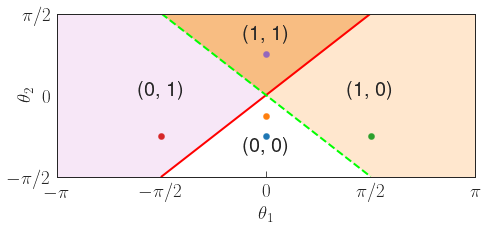

In [180]:
plt.figure(figsize=(7.5,3))
plt.xlim((-np.pi, np.pi))
plt.xticks([0,-np.pi,np.pi,-np.pi/2,np.pi/2], (r'$0$', r'$-\pi$', r'$\pi$', r'$-\pi/2$', r'$\pi/2$'))
plt.ylim((-np.pi/2, np.pi/2))
plt.yticks([0, -np.pi/2, np.pi/2], (r'$0$', r'$-\pi/2$', r'$\pi/2$'))
T = np.linspace(-np.pi/2, np.pi/2, 50)
T1 = np.linspace(-np.pi, 0, 100)
T2 = np.linspace(0,np.pi,100)
T3 = np.linspace(-np.pi/2,np.pi/2,100)
plt.plot(T, T, c='r', linewidth=2)
plt.plot(T, -T, linewidth=2,  c='#00FF00',ls='--')
def f(t):
    if t > np.pi/4:
        return np.pi/4
    elif t <= np.pi/4:
        return t

    
plt.fill_between(T1 ,T1, -T1, color=c4)
plt.fill_between(T2 ,-T2, T2, color=c1)
plt.fill_between(T3, np.ones(100)*np.pi/2, abs(T3), color=c2)



plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$',labelpad=-27)
plt.text(np.pi/2, 0, '(1, 0)', ha='center', fontsize=20)
plt.text(-np.pi/2, 0, '(0, 1)', ha='center', fontsize=20)
plt.text(0, np.pi/4+0.3, '(1, 1)', ha='center', fontsize=20)
plt.text(0, -np.pi/4-0.3, '(0, 0)', ha='center', fontsize=20)
plt.scatter(0,-np.pi/4,s=40)
plt.scatter(0,-np.pi/8,s=40)
plt.scatter(np.pi/2,-np.pi/4,s=40)
plt.scatter(-np.pi/2,-np.pi/4,s=40)
plt.scatter(0,np.pi/4,s=40)
plt.savefig('../Figure/quench_2.pdf')

In [183]:
def E(k, t1, t2):
    return np.arccos(np.cos(k)*np.cos(t1/2)*np.cos(t2/2)-np.sin(t1/2)*np.sin(t2/2))

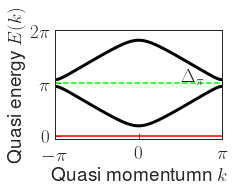

In [217]:
plt.figure(figsize=(3,2))
t1 = np.pi/4
t2 = np.pi/8

t3 = 3*np.pi/4
t4 = np.pi/4

k = np.linspace(-np.pi,np.pi,100)

plt.plot(k, E(k,t1,t2),c='black',lw=3)
plt.plot(k, 2*np.pi-E(k,t1,t2),c='black',lw=3)

# plt.plot(k, E(k,t3,t4),c='black',lw=3,ls='--')
# plt.plot(k, -E(k,t3,t4),c='black',lw=3,ls='--')

plt.plot(k,np.zeros(100),c='r',lw=1.5)
plt.plot(k,np.pi*np.ones(100),c='#00FF00',ls='--',lw=1.5)

plt.xlabel(r'Quasi momentumn $k$')
plt.ylabel(r'Quasi energy $E(k)$')
plt.xlim(-np.pi,np.pi)
plt.ylim(-0.2,2*np.pi)
plt.xticks([-np.pi,0,np.pi],(r'$\mathrm{-\pi}$',r'$0$',r'$\mathrm{\pi}$'))
plt.yticks([0,np.pi,2*np.pi],(r'$0$',r'$\mathrm{\pi}$',r'$\mathrm{2\pi}$'))
plt.text(np.pi/2,np.pi+0.1,r'$\Delta_{\pi}$')
plt.savefig('../Figure/energy1.pdf',bbox_inches = 'tight')

In [219]:
def virtual(theta_1, theta_2, init_state, n0, N):
    p_1 = np.zeros(M+1)
    p_1[0]=1
    a = np.zeros(N)
    b = np.zeros(N)
    for i in range(N): 
        if (i == 0):
            state1 = one_step_4(init_state, theta_1, theta_2)
        elif i > 0 and i < n0:
            state1 = one_step_4(state1, theta_1, theta_2)
        else: 
            state1 = One_step_4(state1, theta_1, theta_2)
        P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
        p_1[i+1] = P1[0] + P1[1]
        a[i] = state1[1][0] / state1[0][0]
        b[i] = state1[1][1] / state1[0][1]
    return p_1, 2*a/(a**2+1), 2*b/(b**2+1)   

<Figure size 576x576 with 0 Axes>

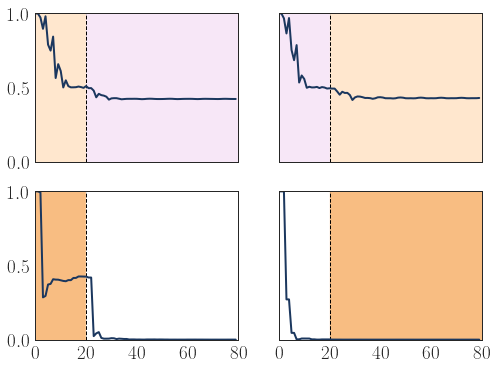

In [222]:
n0 = 20
n1 = 1

N = 80

plt.figure(figsize=(8,8))
fig, axes = plt.subplots(2,2,sharex='col',sharey='row')
theta_1 = np.pi/4
theta_2 = 3*np.pi/4+0.1

p =  virtual(theta_1, theta_2, init_state,n0,N)[0][0:N]
axes[0, 0].plot(range(N), p, c='#1B375E')
axes[0, 0].set_ylim((0,1))
axes[0, 0].set_xlim((0,N))
axes[0, 0].vlines(n0, 0, 1, linestyles = "dashed",lw=1,color='black')
axes[0, 0].fill_between(np.linspace(0,20,25),1,0,color=c1)
axes[0, 0].fill_between(np.linspace(20,N,25),1,0,color=c4)


theta_1 = np.pi/4
theta_2 = -3*np.pi/4

p =  virtual(theta_1, theta_2, init_state,n0,N)[0][0:N]
axes[0, 1].vlines(n0, 0, 1, linestyles = "dashed",lw=1,color='black')
axes[0, 1].plot(range(N), p, c='#1B375E')
axes[0, 1].set_xlim((0,N))
axes[0, 1].fill_between(np.linspace(0,20,25),1,0,color=c4)
axes[0, 1].fill_between(np.linspace(20,N,25),1,0,color=c1)


theta_1 = np.pi/4
theta_2 = -np.pi/8

p =  virtual(theta_1, theta_2, init_state,n0,N)[0][0:N]
axes[1, 0].vlines(n0, 0, 1, linestyles = "dashed",lw=1,color='black')
axes[1, 0].plot(range(N), p, c='#1B375E')
# axes[1, 0].set_xlabel('Steps')
axes[1, 0].set_ylim((0,1))
axes[1, 0].fill_between(np.linspace(0,20,25),1,0,color=c2)
axes[1, 0].fill_between(np.linspace(20,N,25),1,0,color=c3)
axes[1, 0].set_xticks([0,20,40,60,80])

theta_1 = -np.pi/4
theta_2 = 0

p =  virtual(theta_1, theta_2, init_state,n0,N)[0][0:N]
axes[1, 1].vlines(n0, 0, 1, linestyles = "dashed",lw=1,color='black')
axes[1, 1].plot(range(N), p, c='#1B375E')
# axes[1, 1].set_xlabel('Steps')
axes[1, 1].fill_between(np.linspace(0,20,25),1,0,color=c3)
axes[1, 1].fill_between(np.linspace(20,N,25),1,0,color=c2)
axes[1, 1].set_xticks([0,20,40,60,80])

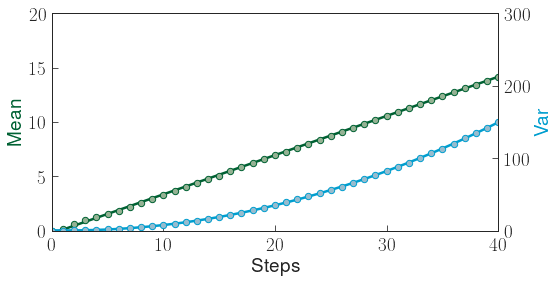

In [83]:
from scipy import optimize
 
def f_1(x, A, B):
    return A * x + B
def f_2(x, A, B, C):
    return A*x**2 +B*x + C

M = 1000
n = 1
N = 500
p1 = np.zeros(801)
p2 = np.zeros(801)
up_state = [0]*M
down_state = [0]*M
aux_state = [0]*M
down_state[0] = 1
np.array(up_state)
np.array(down_state)
np.array(aux_state)
init_state = np.vstack((up_state, down_state, aux_state))
fig = plt.figure(figsize=(8, 4))
mean = np.zeros(50)
var = np.zeros(50)
for i in range(50):
    state = n_step_4(init_state, 0, np.pi/2, N=i)
    P = abs(state[0])**2 + abs(state[1])**2 + abs(state[2])**2
    mean[i] = 0
    for j in range(50):
        mean[i] = mean[i] + P[j]*j
        var[i] = var[i] + P[j]*j**2
    mean[i] = mean[i]
    var[i] =  var[i] - mean[i]**2

A1, B1 = optimize.curve_fit(f_1, range(50), mean)[0]
x1 = range(50)
y1 = A1 * x1 + B1
ax1 = fig.add_subplot(111)

ax1.plot(x1,y1, linewidth=2.5, zorder=1,c='#006133')
ax1.scatter(range(50), mean,zorder=2,c='#95B294',edgecolors='#006133',label='(1, 1)',linewidths=1, \
            marker = 'o', s = 40)
ax1.set_xlim((0,40))
ax1.set_ylim((0,15))
ax1.set_xlabel('Steps')
ax1.set_ylabel('Mean',c='#006133')
ax1.set_yticks([0,5,10,15,20])
ax2 = ax1.twinx()
a=np.polyfit(x1, var, 2)#用2次多项式拟合x，y数组
b=np.poly1d(a)#拟合完之后用这个函数来生成多项式对象
c=b(x1)#生成多项式对象之后，就是获取x在这个多项式处的值
ax2.plot(x1, c, linewidth=2.5, zorder=1, c='#009ECF')
ax2.scatter(range(50), var,zorder=2,c='#98bcce',edgecolors='#009ECF',label='$(0, 0)$',linewidths=1, \
            marker = 'o', s = 40)
ax2.set_ylabel('Var',c='#009ECF')
ax2.set_ylim((0,300))
plt.savefig('../Figure/B1.pdf')

In [90]:
theta_1 = np.pi/2
theta_2 = 0
x = np.linspace(0,10)
p1 = np.zeros(100)
p2 = np.zeros(100)
for i in range(100):
    state1 = n_step_4(init_state,  np.pi/2, 0,N=30)
    state2 = n_step_4(init_state, np.pi/2, 0, N=50)
    P1 = abs(state1[0])**2 + abs(state1[1])**2 + abs(state1[2])**2
    P2 = abs(state2[0])**2 + abs(state2[1])**2 + abs(state2[2])**2
    p1[i] = P1[i]
    p2[i] = P2[i]


(-0.5, 40.0)

<Figure size 576x432 with 0 Axes>

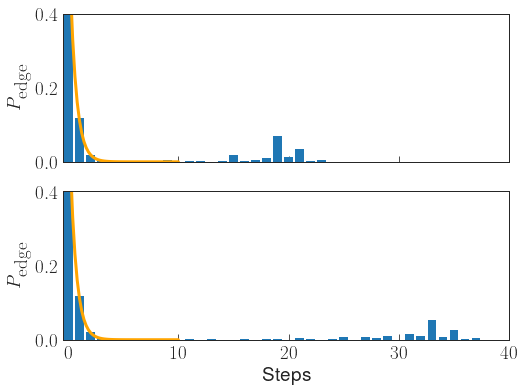

In [92]:
def f(x):
    return pow((np.sqrt(2)-1),x)**2*(1-(np.sqrt(2)-1)**2)/1.22
plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(2,1,sharex='col')

axes[0].set_ylim((0,0.4))
axes[0].bar(range(40),p1[0:40])
axes[0].set_ylabel(r'$P_{\textrm{edge}}$')
axes[0].plot(x, f(x),color='orange',linewidth=3)

axes[1].set_ylim((0,0.4))
axes[1].bar(range(40),p2[0:40])
axes[1].set_ylabel(r'$P_{\textrm{edge}}$')
axes[1].plot(x, f(x),color='orange',linewidth=3)
axes[1].set_xlabel('Steps')
axes[1].set_xlim(-0.5,40)

# axes[2].plot(x1,y1, linewidth=2.5, zorder=1,c='#006133')
# axes[2].scatter(range(50), mean,zorder=2,c='#95B294',edgecolors='#006133',label='(1, 1)',linewidths=1, \
#             marker = 'o', s = 40)
# axes[2].set_xlim((0,40))
# axes[2].set_ylim((0,20))
# axes[2].set_xlabel('Steps')
# axes[2].set_ylabel('Mean',c='#006133')
# axes[2].set_yticks([0,10,20])
# axes[2].set_xticks([0,10,20,30,40])
# ax2 = axes[2].twinx()
# a=np.polyfit(x1, var, 2)#用2次多项式拟合x，y数组
# b=np.poly1d(a)#拟合完之后用这个函数来生成多项式对象
# c=b(x1)#生成多项式对象之后，就是获取x在这个多项式处的值
# ax2.plot(x1, c, linewidth=2.5, zorder=1, c='#009ECF')
# ax2.scatter(range(50), var,zorder=2,c='#98bcce',edgecolors='#009ECF',label='$(0, 0)$',linewidths=1, \
#             marker = 'o', s = 40)
# ax2.set_ylim((0,300))
# ax2.set_ylabel('Var',c='#009ECF')
# plt.savefig('../Figure/B2.pdf')

In [80]:
p2[1]/p2[0]

0.1715728752538099

In [81]:
(np.sqrt(2)-1)**2

0.17157287525381